In [34]:
import sys
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import matplotlib.patches as mpatches
from unet.model import GeneralUNet
from utils.data_utils import BratsDataset3D
from utils.predict import ModelPredict


In [35]:
model = GeneralUNet(in_channels=4,  # Adjust based on your dataset's specifics
                    conv_kernel_size=3,
                    pool_kernel_size=2,
                    up_kernel_size=2,
                    dropout=0.1,
                    conv_stride=1,
                    conv_padding=1,
                    conv3d=True,
                    size=3,  # Adjust the number of layers in the UNet
                    complex=4)  # Adjust the complexity or number of initial features

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_dict = torch.load(r'C:\Users\johns\Downloads\88k_sig_model_dict')
model.load_state_dict(state_dict)
model.to(device)

GeneralUNet(
  (encoder_series): EncoderUNet(
    (blocks): ModuleList(
      (0): EncoderBlock(
        (doubleConv): ConvDouble(
          (doubleLayer): Sequential(
            (0): ConvSingle(
              (layer): Sequential(
                (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
                (3): Dropout3d(p=0.1, inplace=False)
              )
            )
            (1): ConvSingle(
              (layer): Sequential(
                (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
                (3): Dropout3d(p=0.1, inplace=False)
              )
            )
          )
        )
        (maxPool): MaxPool3d(kernel_size=2, stri

In [37]:
scan_dir = r'C:\Users\johns\OneDrive\Desktop\Datasets\ECE-542\brain-tumor-segmentation(nii)\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
scan_index = 0
dataset = BratsDataset3D(scan_dir)

In [38]:
[input_tensor, label_tensor] = dataset.__getitem__(scan_index)

# Move input to GPU
input_tensor = input_tensor.to(device)
input_tensor = torch.unsqueeze(input_tensor, 0)

In [50]:
model_output = model(input_tensor)

In [54]:
binary_output = torch.where(model_output < model_output.max()/2, torch.zeros_like(model_output), torch.ones_like(model_output))

In [55]:
scan_np  = input_tensor.squeeze().cpu().numpy()
pred_np  = binary_output.squeeze().detach().cpu().numpy()  
label_np = label_tensor.squeeze().cpu().numpy()  
print(scan_np.shape)
print(pred_np.shape)
print(label_np.shape)

(4, 240, 240, 155)
(240, 240, 155)
(240, 240, 155)


In [56]:
print(pred_np.max())

1.0


<Figure size 640x480 with 0 Axes>

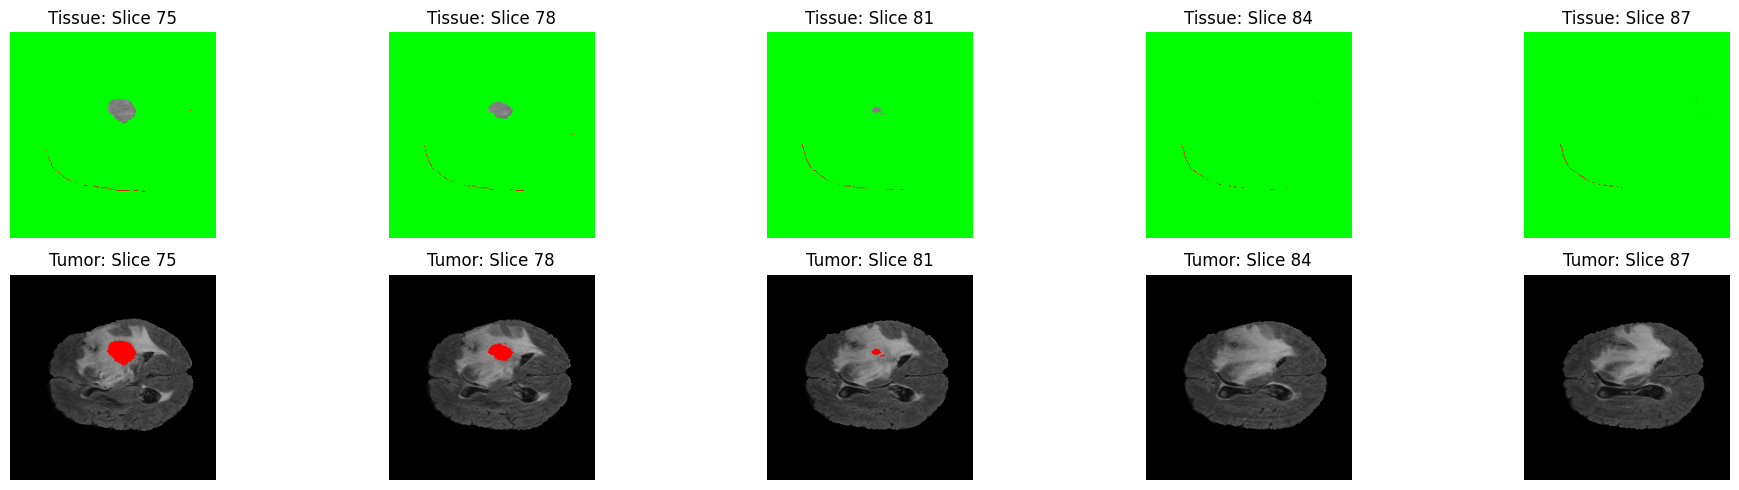

In [57]:
num_slices = 5
middle_slice = 75  # Adjust as needed
num_rows = 1
num_cols = num_slices

tissue_class_value = 0 
tumor_class_value = 1

# Create custom legend
green_patch = mpatches.Patch(color='green', label='Correct Prediction')
red_patch = mpatches.Patch(color='red', label='Incorrect Prediction')
plt.figlegend(handles=[green_patch, red_patch], loc='upper right')

plt.figure(figsize=(20, 5))

for i in range(num_slices):
    current_slice = middle_slice + 3 * i
    scan_slice = scan_np[0, :, :, current_slice] if scan_np.ndim == 4 else scan_np[:, :, current_slice]
    pred_slice = pred_np[:, :, current_slice]
    truth_slice = label_np[:, :, current_slice]

    correct_tissue = (pred_slice == truth_slice) & (truth_slice == tissue_class_value)
    incorrect_tissue = (pred_slice != truth_slice) & (truth_slice == tissue_class_value)

    correct_tumor = (pred_slice == truth_slice) & (truth_slice == tumor_class_value)
    incorrect_tumor = (pred_slice != truth_slice) & (truth_slice == tumor_class_value)

    overlay_tissue = dataset.create_overlay(scan_slice, correct_tissue, incorrect_tissue)
    overlay_tumor = dataset.create_overlay(scan_slice, correct_tumor, incorrect_tumor)

    plt.subplot(2, num_slices, i + 1)
    plt.imshow(overlay_tissue)
    plt.title(f'Tissue: Slice {current_slice}')
    plt.axis('off')
    
    # Plot tumor overlay
    plt.subplot(2, num_slices, num_slices + i + 1)
    plt.imshow(overlay_tumor)
    plt.title(f'Tumor: Slice {current_slice}')
    plt.axis('off')


plt.tight_layout()
plt.show()

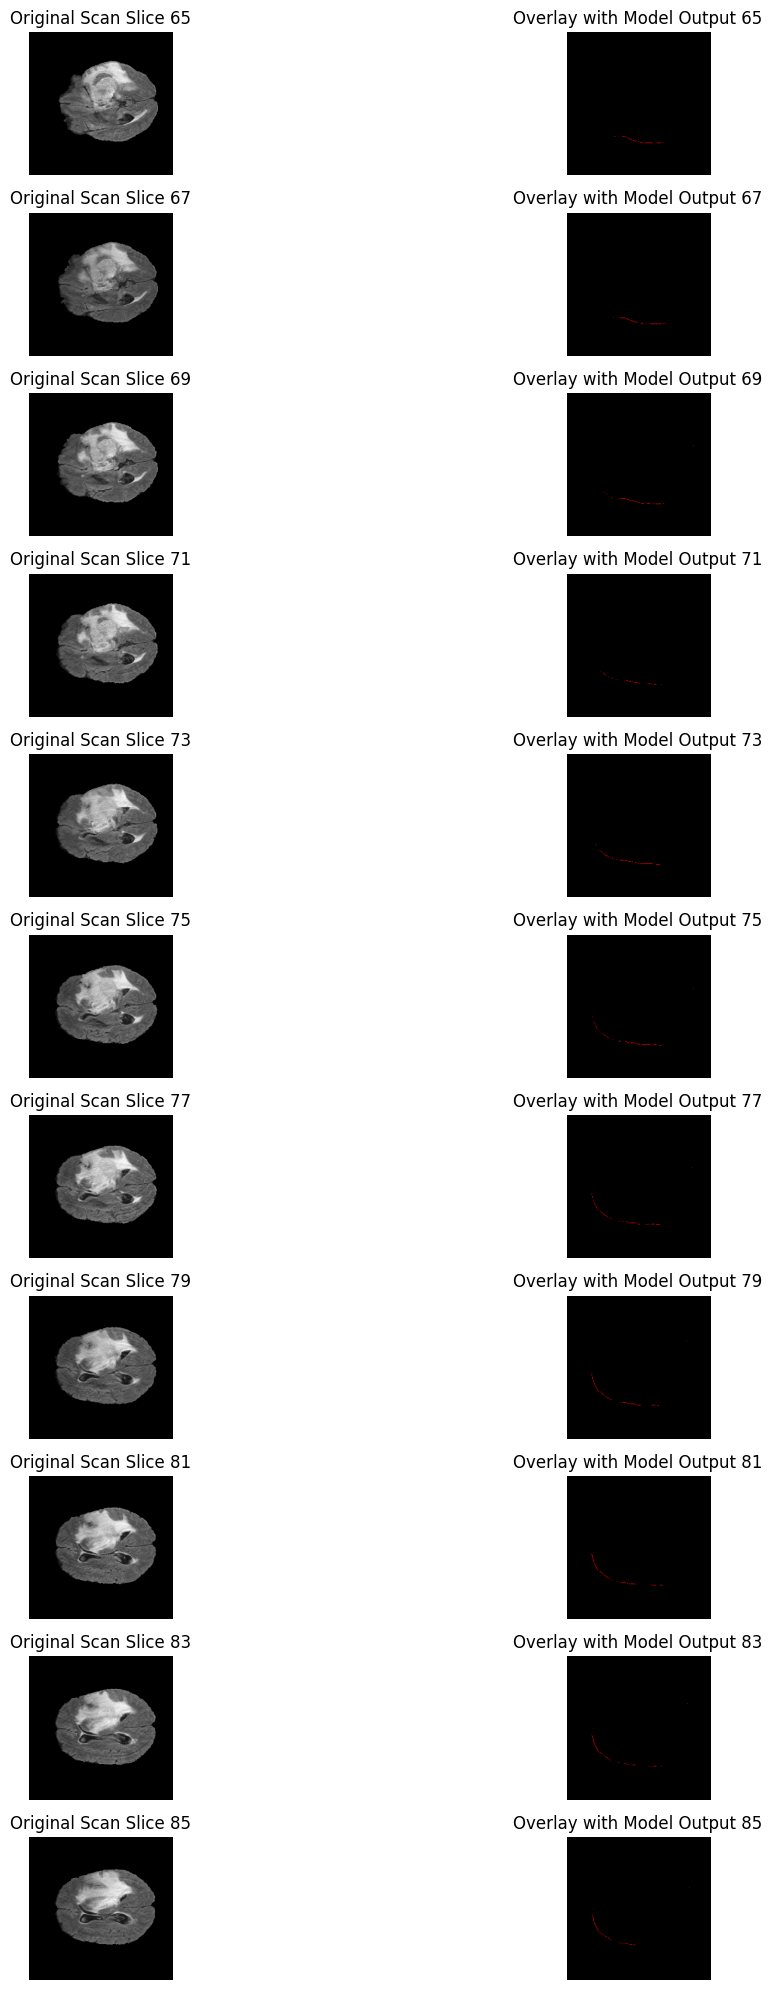

In [58]:
# Define the central slice and the range around it
central_slice = 75
offset = 10  # 5 steps on each side with a step of 2

# Generate the list of slice indices
slice_indices = list(range(central_slice - offset, central_slice + offset + 1, 2))  # Slices around central slice

# Create a figure to hold all subplots
plt.figure(figsize=(15, 20))  # Adjust the size as needed

for i, slice_number in enumerate(slice_indices, start=1):
    # Extract the corresponding slice from the scan and the prediction
    scan_slice = scan_np[0, :, :, slice_number]  # Taking the first channel
    pred_slice = pred_np[:, :, slice_number]

    # Create an RGB version of the gray-scale scan slice for overlay
    overlay = np.repeat(scan_slice[:, :, np.newaxis], 3, axis=2)
    # Set the overlay color for the prediction, here using red for the positive class (1)
    overlay[pred_slice == 1, 0] = 255  # Increasing red channel intensity

    # Plotting the original scan slice
    plt.subplot(len(slice_indices), 2, 2*i-1)  # Arrange plots in len(slice_indices) rows and 2 columns
    plt.imshow(scan_slice, cmap='gray')
    plt.title(f'Original Scan Slice {slice_number}')
    plt.axis('off')  # Hide axis for clarity

    # Plotting the overlay slice
    plt.subplot(len(slice_indices), 2, 2*i)  # Next to the original slice
    plt.imshow(overlay.astype(np.uint8))  # Convert to uint8 for displaying
    plt.title(f'Overlay with Model Output {slice_number}')
    plt.axis('off')  # Hide axis for clarity

plt.tight_layout()
plt.show()
